# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform 
$$
k(z) = \begin{cases} 
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is 
$$
k(z) = \begin{cases} 
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

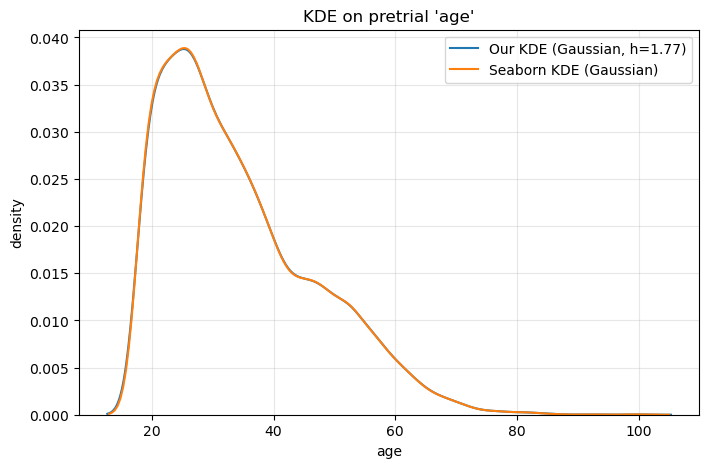

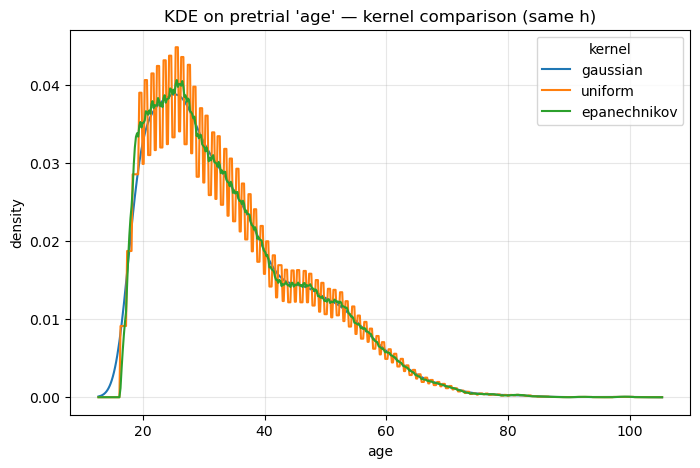

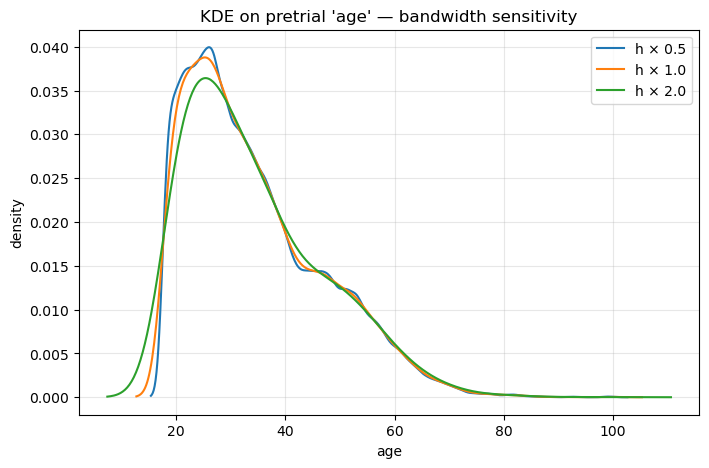

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# --- Silverman's plug-in bandwidth (class formula) ---
def silverman_bw(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    sd = np.std(x, ddof=1)
    return 1.06 * sd * n**(-1/5)

# --- Kernel functions ---
def _kernel(z, kind: str):
    if kind == "gaussian":
        return np.exp(-0.5 * z**2) / np.sqrt(2*np.pi)
    elif kind == "uniform":          # “bump” kernel
        return np.where(np.abs(z) <= 1, 0.5, 0.0)
    elif kind == "epanechnikov":
        return np.where(np.abs(z) <= 1, 0.75*(1 - z**2), 0.0)
    else:
        raise ValueError("kernel must be 'gaussian', 'uniform', or 'epanechnikov'")

# --- Your KDE estimator (no seaborn/scipy KDE helpers) ---
def kde1d(data, bandwidth=None, kernel="gaussian", gridsize=512, cut=3.0):
    x = pd.Series(data).dropna().astype(float).to_numpy()
    if x.size == 0:
        raise ValueError("No finite observations in data.")
    h = silverman_bw(x) if bandwidth is None else float(bandwidth)

    grid = np.linspace(x.min() - cut*h, x.max() + cut*h, gridsize)
    z = cdist(x.reshape(-1,1), grid.reshape(-1,1), metric="euclidean") / h
    K = _kernel(z, kernel)
    density = K.sum(axis=0) / (x.size * h)
    return grid, density, h

# -----------------------------
# Demo on class pretrial data
# -----------------------------
df = pd.read_csv("/Users/lingyueji/Desktop/DS3001/visualization_assignment-main/data/pretrial_data.csv")       
x = df["age"]                                       # numeric variable used in lecture

# Our KDE (Gaussian default with Silverman bandwidth)
g, d, h = kde1d(x, kernel="gaussian")
plt.figure(figsize=(8,5))
plt.plot(g, d, label=f"Our KDE (Gaussian, h={h:.2f})")
sns.kdeplot(x=x, label="Seaborn KDE (Gaussian)")    # visual check
plt.title("KDE on pretrial 'age'")
plt.xlabel("age"); plt.ylabel("density"); plt.grid(True, alpha=.3); plt.legend()
plt.show()

# Alternative kernels (same bandwidth)
plt.figure(figsize=(8,5))
for k in ["gaussian","uniform","epanechnikov"]:
    g, d, _ = kde1d(x, bandwidth=h, kernel=k)
    plt.plot(g, d, label=k)
plt.title("KDE on pretrial 'age' — kernel comparison (same h)")
plt.xlabel("age"); plt.ylabel("density"); plt.grid(True, alpha=.3); plt.legend(title="kernel")
plt.show()

# Bandwidth sensitivity (under/over-smoothing)
scales = [0.5, 1.0, 2.0]
plt.figure(figsize=(8,5))
for s in scales:
    g, d, _ = kde1d(x, bandwidth=s*h, kernel="gaussian")
    plt.plot(g, d, label=f"h × {s}")
plt.title("KDE on pretrial 'age' — bandwidth sensitivity")
plt.xlabel("age"); plt.ylabel("density"); plt.grid(True, alpha=.3); plt.legend()
plt.show()

  

I implemented a 1-D KDE with a Gaussian kernel and Silverman’s bandwidth (h ≈ 1.77) and verified it by matching Seaborn’s KDE. Gaussian and Epanechnikov give very similar shapes; the uniform kernel looks choppier due to its hard edges. Varying h shows the bias–variance trade-off: smaller h adds noisy bumps, larger h oversmooths. For the pretrial age data, the density is right-skewed with a main mode in the early-to-mid 20s and a long tail to older ages.

**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

In [ ]:
# Question 2.1
import pandas as pd
df = pd.read_csv('/Users/lingyueji/Desktop/DS3001/visualization_assignment-main/data/college_completion.csv')

In [ ]:
# Question 2.2
print("Data dimensions (rows, columns):", df.shape)
print("\nNumber of observations:", df.shape[0])
print("Number of variables:", df.shape[1])
print("\nVariables included:", list(df.columns))
print("\nFirst few rows of data:")
print(df.head())

Data dimensions (rows, columns): (3798, 63)

Number of observations: 3798
Number of variables: 63

Variables included: ['index', 'unitid', 'chronname', 'city', 'state', 'level', 'control', 'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count', 'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value', 'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value', 'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile', 'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile', 'endow_value', 'endow_percentile', 'grad_100_value', 'grad_100_percentile', 'grad_150_value', 'grad_150_percentile', 'pell_value', 'pell_percentile', 'retain_value', 'retain_percentile', 'ft_fac_value', 'ft_fac_percentile', 'vsa_year', 'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first', 'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first', 'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first', 'vsa_enroll_after6_first', 'vsa_enroll_elsew

In [ ]:
# Question 2.3
# Cross tabulate control and level
cross_tab = pd.crosstab(df['control'], df['level'])
print("Cross tabulation of control vs level:")
print(cross_tab)
print("\n")

# Add row and column totals for better understanding
cross_tab_with_totals = pd.crosstab(df['control'], df['level'], margins=True, margins_name="Total")
print("Cross tabulation with totals:")
print(cross_tab_with_totals)
print("\n")

# Calculate percentages
cross_tab_percent = pd.crosstab(df['control'], df['level'], normalize=True) * 100
print("Percentage distribution:")
print(cross_tab_percent.round(2))
print("\n")

Cross tabulation of control vs level:
level                   2-year  4-year
control                               
Private for-profit         465     527
Private not-for-profit      68    1180
Public                     926     632


Cross tabulation with totals:
level                   2-year  4-year  Total
control                                      
Private for-profit         465     527    992
Private not-for-profit      68    1180   1248
Public                     926     632   1558
Total                     1459    2339   3798


Percentage distribution:
level                   2-year  4-year
control                               
Private for-profit       12.24   13.88
Private not-for-profit    1.79   31.07
Public                   24.38   16.64




I observed clear patterns emerge in institutional distribution. Public colleges form the largest segment at 41% of all institutions. Private non-profits show strong specialization in 4-year programs. A striking 95% of their offerings are bachelor's degree tracks. Private for-profits maintain a more balanced approach between program levels. They operate 53% 2-year programs and 47% 4-year programs. Public institutions dominate the 2-year college landscape, and they represent 63% of all associate degree and certificate providers. Private non-profits lead the 4-year education market, and they comprise 50% of all bachelor's degree institutions. This reflects the historical development of American higher education. Each sector appears to fill distinct educational roles.

ANALYSIS OF grad_100_value (100% Completion Rate)

Statistical Description:
count    3467.00
mean       28.36
std        23.31
min         0.00
25%         9.00
50%        22.50
75%        43.65
max       100.00
Name: grad_100_value, dtype: float64

Missing values: 331


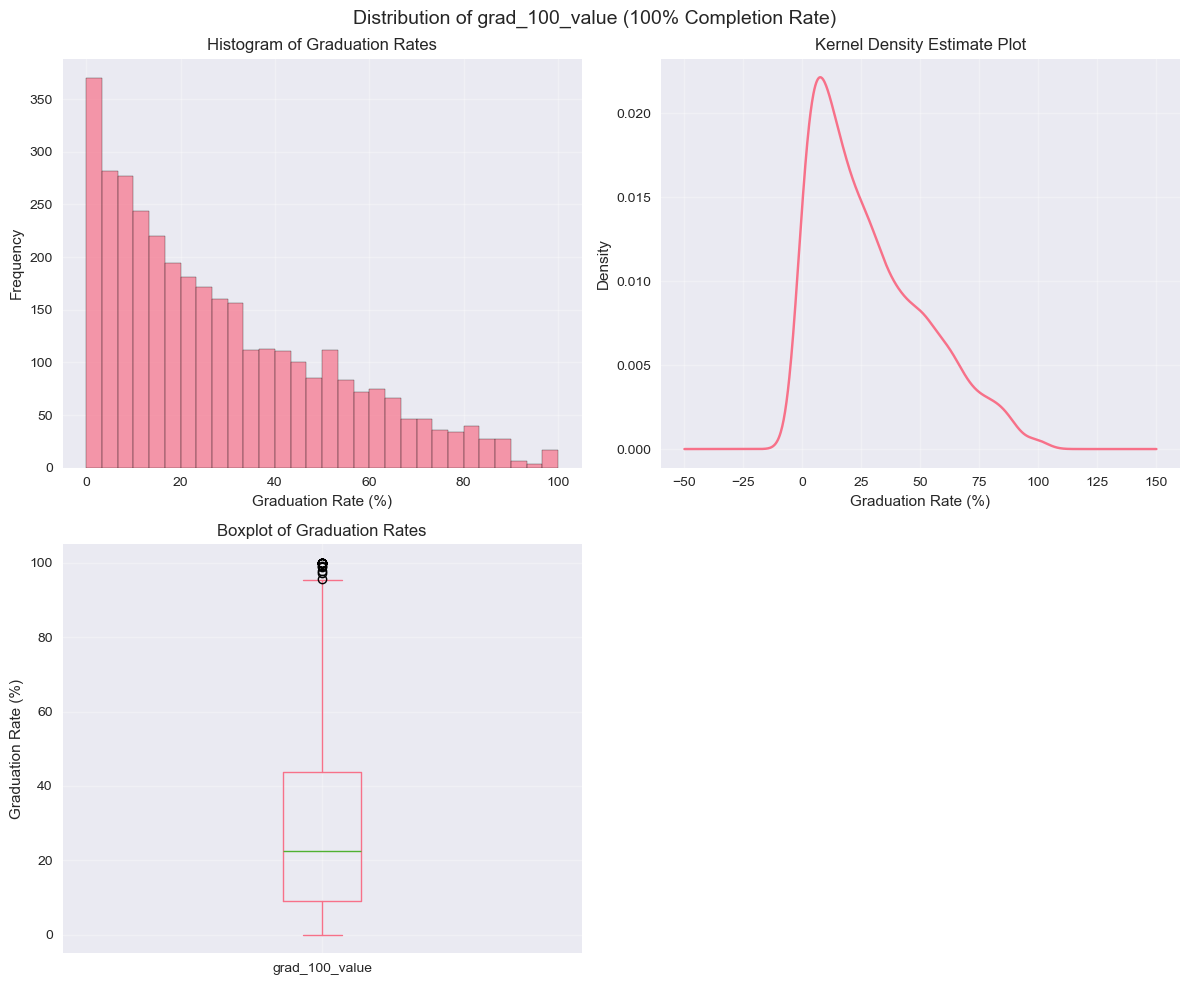


Additional Insights:
Median graduation rate: 22.50%
Mode graduation rate: 0.00%
Range: 100.00%
IQR (Q3-Q1): 34.65%
Skewness: 0.83
Kurtosis: -0.11


In [ ]:
# Question 2.4
print("=" * 60)
print("ANALYSIS OF grad_100_value (100% Completion Rate)")
print("=" * 60)

# Statistical description
print("\nStatistical Description:")
print(df['grad_100_value'].describe().round(2))

# Check for missing values
missing_count = df['grad_100_value'].isnull().sum()
print(f"\nMissing values: {missing_count}")

# Create subplots for visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Distribution of grad_100_value (100% Completion Rate)', fontsize=14)

# Histogram
axes[0, 0].hist(df['grad_100_value'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Graduation Rate (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Histogram of Graduation Rates')
axes[0, 0].grid(True, alpha=0.3)

# Kernel Density Plot
df['grad_100_value'].dropna().plot(kind='density', ax=axes[0, 1])
axes[0, 1].set_xlabel('Graduation Rate (%)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Kernel Density Estimate Plot')
axes[0, 1].grid(True, alpha=0.3)

# Boxplot
df['grad_100_value'].dropna().plot(kind='box', ax=axes[1, 0])
axes[1, 0].set_ylabel('Graduation Rate (%)')
axes[1, 0].set_title('Boxplot of Graduation Rates')
axes[1, 0].grid(True, alpha=0.3)

# Leave the fourth subplot empty or remove it
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Additional statistical insights
grad_data = df['grad_100_value'].dropna()
print("\nAdditional Insights:")
print(f"Median graduation rate: {grad_data.median():.2f}%")
print(f"Mode graduation rate: {grad_data.mode().values[0]:.2f}%")
print(f"Range: {grad_data.max() - grad_data.min():.2f}%")
print(f"IQR (Q3-Q1): {grad_data.quantile(0.75) - grad_data.quantile(0.25):.2f}%")
print(f"Skewness: {skew(grad_data):.2f}")
print(f"Kurtosis: {kurtosis(grad_data):.2f}")

Statistical Description:

Sample Size: 3,467 institutions with graduation rate data

Missing Data: 331 institutions missing graduation rate information

Average Rate: 28.36% mean graduation rate

Variability: High standard deviation (23.31%) indicating wide differences

Range: From 0% to 100% completion rates


25% of institutions have ≤9% graduation rate

50% have ≤22.5% (median)

75% have ≤43.65%

Median graduation rate: 22.59%

Mode graduation rate: 0.00%

Range: 100.00%

IQR (Q3-Q1): 34.65%

Skewness: 8.83

Kurtosis: -0.11



GROUPED ANALYSIS OF grad_100_value


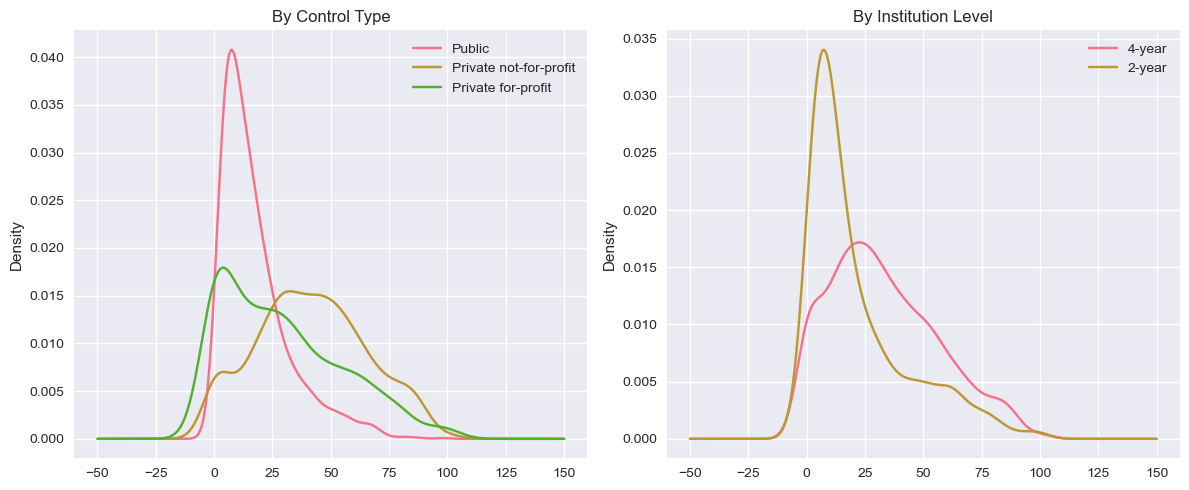


GRADUATION RATES BY CONTROL TYPE:
                         count   mean    std  min    25%   50%    75%    max
control                                                                     
Private for-profit       779.0  29.11  25.60  0.0   6.95  24.7  46.75  100.0
Private not-for-profit  1189.0  41.66  23.55  0.0  25.00  41.0  58.30  100.0
Public                  1499.0  17.43  14.73  0.0   6.90  13.2  23.25   97.8

GRADUATION RATES BY LEVEL:
         count   mean    std  min   25%   50%    75%    max
level                                                      
2-year  1455.0  21.64  21.65  0.0   6.0  13.0  30.60  100.0
4-year  2012.0  33.23  23.27  0.0  15.2  29.7  49.22  100.0

BEST PERFORMING INSTITUTIONS:
By control type (highest first):
control
Private not-for-profit    41.66
Private for-profit        29.11
Public                    17.43
Name: grad_100_value, dtype: float64

By level (highest first):
level
4-year    33.23
2-year    21.64
Name: grad_100_value, dtype: float64


In [ ]:
# Question 2.5
print("GROUPED ANALYSIS OF grad_100_value")
print("=" * 40)

# Grouped density plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# By control type
for control in df['control'].unique():
    data = df[df['control'] == control]['grad_100_value'].dropna()
    data.plot(kind='density', label=control, ax=ax1)
ax1.set_title('By Control Type')
ax1.legend()

# By level
for level in df['level'].unique():
    data = df[df['level'] == level]['grad_100_value'].dropna()
    data.plot(kind='density', label=level, ax=ax2)
ax2.set_title('By Institution Level')
ax2.legend()

plt.tight_layout()
plt.show()

# Grouped statistics
print("\nGRADUATION RATES BY CONTROL TYPE:")
print(df.groupby('control')['grad_100_value'].describe().round(2))

print("\nGRADUATION RATES BY LEVEL:")
print(df.groupby('level')['grad_100_value'].describe().round(2))

# Best performing institutions
print("\nBEST PERFORMING INSTITUTIONS:")
control_means = df.groupby('control')['grad_100_value'].mean().round(2)
level_means = df.groupby('level')['grad_100_value'].mean().round(2)

print("By control type (highest first):")
print(control_means.sort_values(ascending=False))

print("\nBy level (highest first):")
print(level_means.sort_values(ascending=False))

The density plots show clear patterns across institution types. Private not-for-profit schools have a right-skewed distribution with higher graduation rates, while public institutions cluster at lower rates. Private for-profit schools show a bimodal pattern with both low and moderate peaks. Four-year colleges overall show higher completion rates than two-year institutions, with broader distribution across the performance spectrum.

Private not-for-profit institutions have the best graduation rates at 41.66% on average. These schools, particularly four-year private non-profits, demonstrate the highest performance levels with strong median rates and upper quartile results, indicating consistent effectiveness across most institutions in this category.

ANALYSIS BY LEVEL-CONTROL COMBINATION


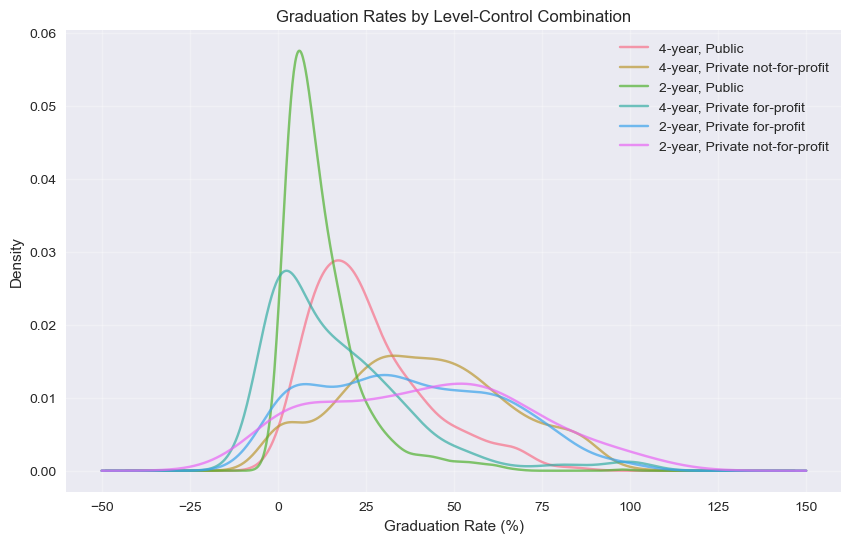


GRADUATION RATES BY LEVEL-CONTROL COMBINATION:
                                 count   mean    std  min    25%   50%    75%  \
levelXcontrol                                                                   
2-year, Private for-profit       461.0  37.20  25.50  0.0  15.80  33.9  57.80   
2-year, Private not-for-profit    68.0  41.91  28.35  0.0  16.23  44.4  61.20   
2-year, Public                   926.0  12.40  10.89  0.0   5.10   9.4  16.18   
4-year, Private for-profit       318.0  17.38  20.79  0.0   0.00  12.5  26.32   
4-year, Private not-for-profit  1121.0  41.65  23.24  0.0  25.00  41.0  57.80   
4-year, Public                   573.0  25.56  16.40  0.0  13.60  21.8  33.80   

                                  max  
levelXcontrol                          
2-year, Private for-profit      100.0  
2-year, Private not-for-profit  100.0  
2-year, Public                   97.8  
4-year, Private for-profit      100.0  
4-year, Private not-for-profit  100.0  
4-year, Public         

In [ ]:
# Question 2.6
print("ANALYSIS BY LEVEL-CONTROL COMBINATION")
print("=" * 40)

# Create new interaction variable
df['levelXcontrol'] = df['level'] + ', ' + df['control']

# Grouped density plot
plt.figure(figsize=(10, 6))
for combo in df['levelXcontrol'].unique():
    data = df[df['levelXcontrol'] == combo]['grad_100_value'].dropna()
    data.plot(kind='density', label=combo, alpha=0.7)

plt.title('Graduation Rates by Level-Control Combination')
plt.xlabel('Graduation Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistical analysis
print("\nGRADUATION RATES BY LEVEL-CONTROL COMBINATION:")
combo_stats = df.groupby('levelXcontrol')['grad_100_value'].describe().round(2)
print(combo_stats)

# Rank by mean performance
print("\nRANKED PERFORMANCE (Highest to Lowest):")
ranked_means = df.groupby('levelXcontrol')['grad_100_value'].mean().sort_values(ascending=False)
print(ranked_means.round(2))

Private not-for-profit institutions have the best graduation rates, with 2-year private not-for-profit leading at 41.91% and 4-year private not-for-profit close behind at 41.65%. These significantly outperform all other institution types. The worst performers are 2-year public colleges at 12.40% and 4-year private for-profit institutions at 17.38%.

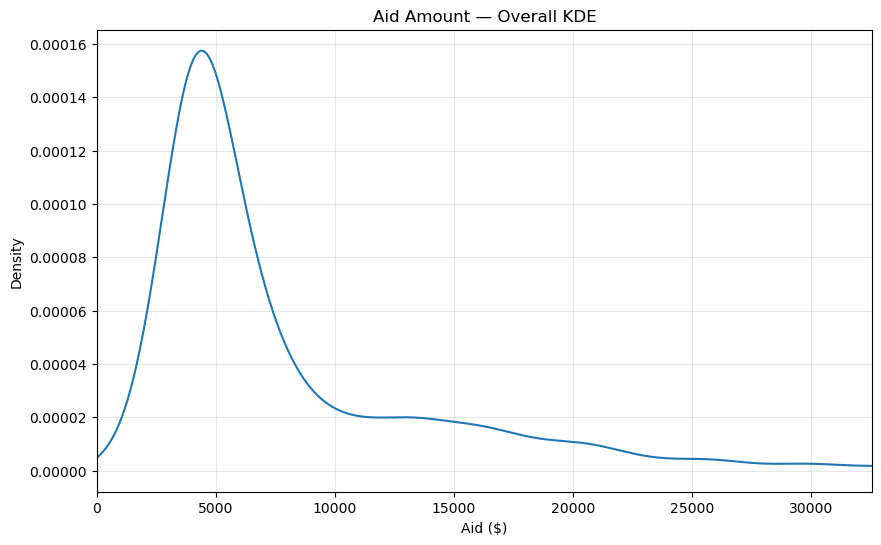

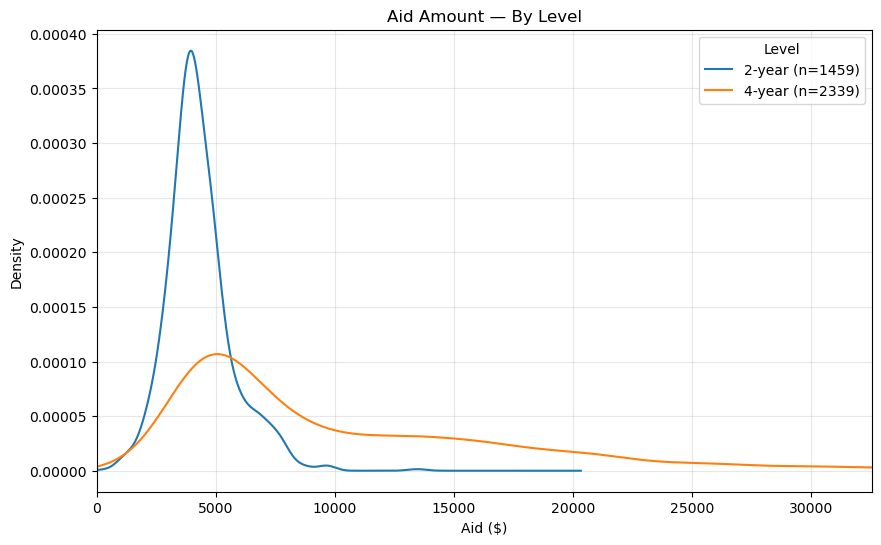

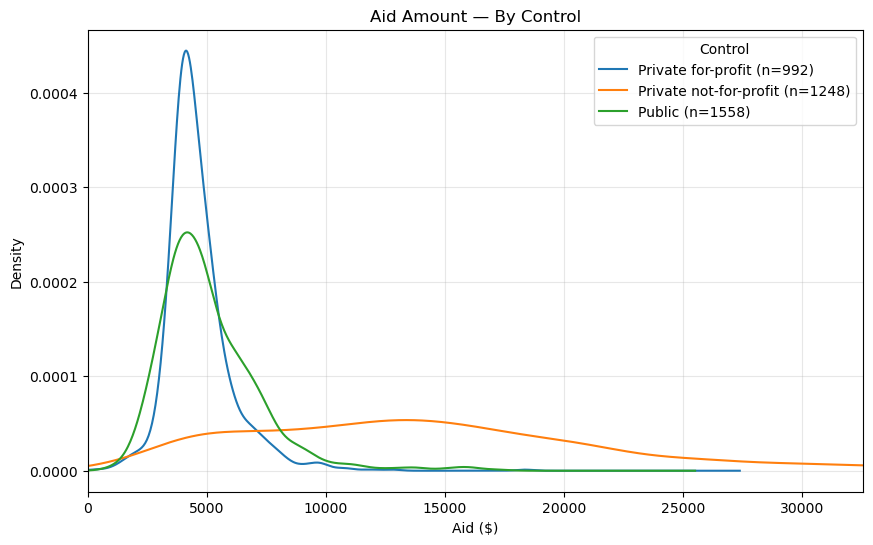

aid_value by level:
         count      mean      std    min     25%     50%      75%      max
level                                                                     
2-year  1458.0   4310.88  1384.05  294.0  3485.5  4113.0   4890.0  13654.0
4-year  2339.0  10235.38  7227.37  902.0  4830.5  7222.0  14046.0  41580.0 

aid_value by control:
                         count      mean      std    min      25%      50%  \
control                                                                      
Private for-profit       991.0   4632.21  1399.12  294.0  3861.50   4331.0   
Private not-for-profit  1248.0  14180.72  7772.70  902.0  8325.00  13322.0   
Public                  1558.0   5094.84  2136.44  881.0  3725.25   4667.0   

                            75%      max  
control                                   
Private for-profit       5131.5  18355.0  
Private not-for-profit  18571.0  41580.0  
Public                   6087.5  17299.0  


In [ ]:
# Question 2.7
try:
    df
except NameError:
    df = pd.read_csv("./data/college_completion.csv")

# Clean to numeric ($, commas, stray text)
def coerce_dollars(x):
    return pd.to_numeric(pd.Series(x).astype(str).str.replace(r"[^0-9.\-]", "", regex=True), errors="coerce")
df["aid_value"] = coerce_dollars(df["aid_value"])

# Common x-limits for fair comparison
xmin, xmax = 0, np.nanpercentile(df["aid_value"], 99)

# 1) Overall KDE
plt.figure(figsize=(10,6))
df["aid_value"].dropna().plot(kind="density")
plt.title("Aid Amount — Overall KDE")
plt.xlabel("Aid ($)")
plt.xlim(xmin, xmax)
plt.grid(True, alpha=0.3)
plt.show()

# 2) KDE by LEVEL
plt.figure(figsize=(10,6))
for g, gdf in df.groupby("level"):
    gdf["aid_value"].dropna().plot(kind="density", label=f"{g} (n={len(gdf)})")
plt.title("Aid Amount — By Level")
plt.xlabel("Aid ($)")
plt.xlim(xmin, xmax)
plt.legend(title="Level")
plt.grid(True, alpha=0.3)
plt.show()

# 3) KDE by CONTROL
plt.figure(figsize=(10,6))
for g, gdf in df.groupby("control"):
    gdf["aid_value"].dropna().plot(kind="density", label=f"{g} (n={len(gdf)})")
plt.title("Aid Amount — By Control")
plt.xlabel("Aid ($)")
plt.xlim(xmin, xmax)
plt.legend(title="Control")
plt.grid(True, alpha=0.3)
plt.show()

# 4) Grouped stats (for the write-up)
print("aid_value by level:")
print(df.groupby("level")["aid_value"].describe().round(2), "\n")
print("aid_value by control:")
print(df.groupby("control")["aid_value"].describe().round(2))


The overall KDE is right-skewed because it mixes very different groups. Two-year colleges and most public/for-profit schools cluster around 4,000–6,500 dollar in aid (means roughly 4,300–5,100 dollar), which creates the left peak. Four-year private not-for-profits offer much larger and more variable aid (mean about 14,200 dollar; IQR about 8,300–18,600 dollar; maximum about 41,600 dollar), producing the higher second hump and the long right tail. Mixing these heterogeneous distributions yields the wide spread and the bimodal shape in the overall curve.

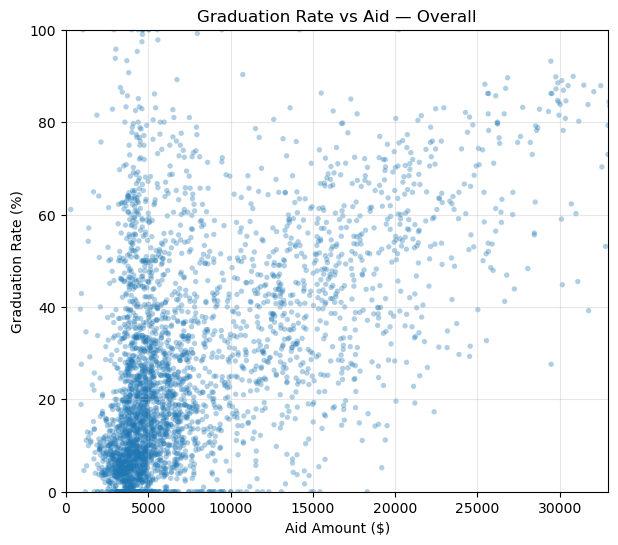

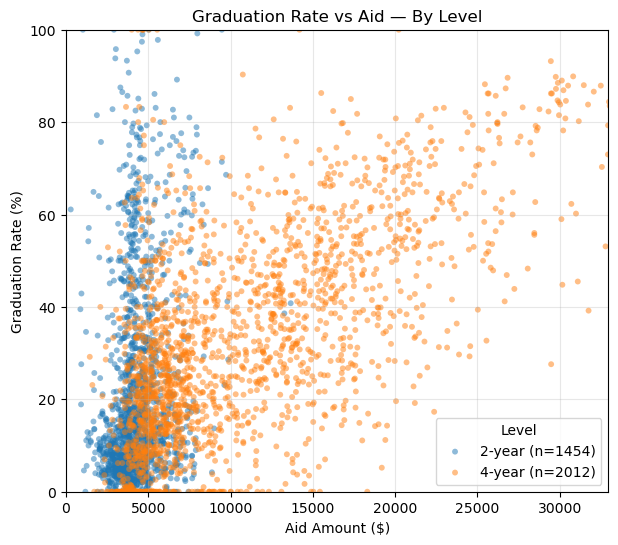

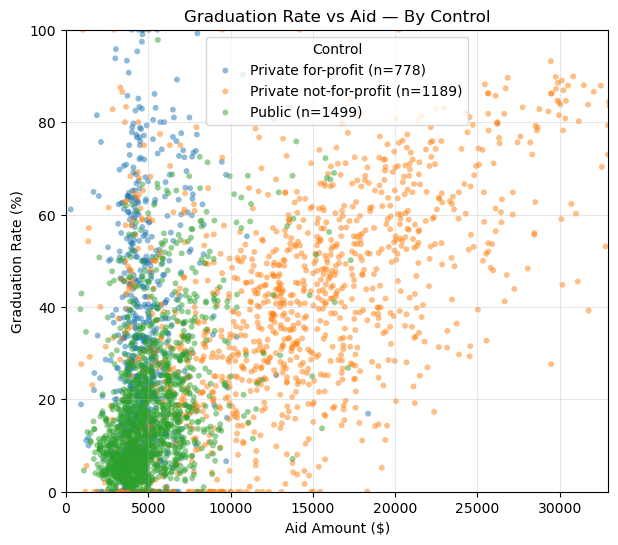

CORRELATION COEFFICIENTS
Overall: 0.576

By Level:
  2-year: 0.211
  4-year: 0.670

By Control:
  Private for-profit: 0.188
  Private not-for-profit: 0.602
  Public: 0.482


In [ ]:
# Question 2.8
path = "/Users/lingyueji/Desktop/DS3001/visualization_assignment-main/data/college_completion.csv"
df = pd.read_csv(path)

# 1) Light cleanup so the expected columns exist and are numeric
df.columns = df.columns.str.strip()

# Standardize names if they came in with different cases/spaces
rename_map = {}
for c in df.columns:
    lc = c.lower().strip()
    if lc == "aid_value":        rename_map[c] = "aid_value"
    if lc == "grad_100_value":   rename_map[c] = "grad_100_value"
    if lc == "level":            rename_map[c] = "level"
    if lc == "control":          rename_map[c] = "control"
df = df.rename(columns=rename_map)

# Coerce numerics (handles $ and commas if present)
for col in ["aid_value", "grad_100_value"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r"[^0-9.\-]", "", regex=True)
        .replace({"": np.nan})
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Keep only rows with x/y and needed columns
use_cols = ["aid_value", "grad_100_value", "level", "control"]
d = df[use_cols].dropna(subset=["aid_value", "grad_100_value"]).copy()

# Common axis limits for fair comparison
xmin, xmax = 0, np.nanpercentile(d["aid_value"], 99)  # trim extreme x-outliers for readability
ymin, ymax = 0, 100

# 2) Overall scatter
plt.figure(figsize=(7, 6))
plt.scatter(d["aid_value"], d["grad_100_value"], s=15, alpha=0.35, edgecolor="none")
plt.xlabel("Aid Amount ($)")
plt.ylabel("Graduation Rate (%)")
plt.title("Graduation Rate vs Aid — Overall")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(True, alpha=0.3)
plt.show()

# 3) Grouped by LEVEL
plt.figure(figsize=(7, 6))
for g, gdf in d.groupby("level"):
    plt.scatter(gdf["aid_value"], gdf["grad_100_value"],
                s=18, alpha=0.5, edgecolor="none", label=f"{g} (n={len(gdf)})")
plt.xlabel("Aid Amount ($)")
plt.ylabel("Graduation Rate (%)")
plt.title("Graduation Rate vs Aid — By Level")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend(title="Level")
plt.grid(True, alpha=0.3)
plt.show()

# 4) Grouped by CONTROL
plt.figure(figsize=(7, 6))
for g, gdf in d.groupby("control"):
    plt.scatter(gdf["aid_value"], gdf["grad_100_value"],
                s=18, alpha=0.5, edgecolor="none", label=f"{g} (n={len(gdf)})")
plt.xlabel("Aid Amount ($)")
plt.ylabel("Graduation Rate (%)")
plt.title("Graduation Rate vs Aid — By Control")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend(title="Control")
plt.grid(True, alpha=0.3)
plt.show()

# 5) Correlations for your write-up
def pearson(x, y):
    return float(np.corrcoef(x, y)[0, 1])

print("CORRELATION COEFFICIENTS")
print(f"Overall: {pearson(d['aid_value'], d['grad_100_value']):.3f}\n")

print("By Level:")
for g, gdf in d.groupby("level"):
    print(f"  {g}: {pearson(gdf['aid_value'], gdf['grad_100_value']):.3f}")

print("\nBy Control:")
for g, gdf in d.groupby("control"):
    print(f"  {g}: {pearson(gdf['aid_value'], gdf['grad_100_value']):.3f}")


The scatterplots show a clear positive association between financial aid and graduation rates overall (r = 0.576). The strength of this relationship depends on institution type: four-year colleges display a much stronger association (r = 0.670) than two-year colleges (r = 0.211). By control, private not-for-profit institutions have the strongest link between aid and graduation (r = 0.602), followed by public schools (r = 0.482), while private for-profit institutions show the weakest relationship (r = 0.188).

Taken together, aid appears most effective at boosting graduation in four-year and private not-for-profit settings, where the point clouds tilt upward as aid increases. In contrast, two-year colleges and private for-profits show only a modest rise, with dense clusters at low aid and lower completion—suggesting a much weaker connection between aid levels and graduation outcomes in those sectors.